# Tutorial - Custom serialization protocols

`dds` can accomodate a large assortment of python objects by default, using the python `pickle` module. Sometimes, though, it can be useful to give a special treatment for some types of objects:

 - if the object is not compatible with the default `pickle` module
 - if the default behaviour is not desirable, for example because it is too slow or not compatible with downstream applications
 
This tutorial is going to show how to change the storage representation of objects. Let us start with a datafunction that returns a list of statistics:

In [1]:
! rm -rf /tmp/dds/tut_custom_types

We are going first to define _where_ our final data will be stored, which will be in a local temporary directory for the sake of this example. If the concept of data directory is unfamiliar, consult the user guide.

In [2]:
data_dir = "/tmp/dds/tut_custom_types/data_main"

The next cell instructs `dds` to store the content to the data directory, with the associated blob directory.

In [3]:
import dds

dds.set_store("local",
              data_dir=data_dir,
              internal_dir="/tmp/dds/tut_custom_types/internal")

As an example throughout this tutorial, we are going to have a function that returns an image, in this case of type `png`. This image will be loaded through the `PIL` library. As usual, Jupyter can directly display the image that we load and it can be wrapped as a data function with `dds`.

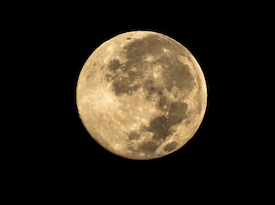

In [4]:
from PIL import Image
import dds

@dds.data_function("/my_image")
def image_moon():
    return Image.open('tut_custom_types_moon.png')

image_moon()

Because we are using `dds`, the image object is also stored under the path `my_image` into the data directory. However, if we try to directly load that image, using Jupyter's image display facilities, it will fail:

In [5]:
import IPython.display
IPython.display.Image(filename=f'{data_dir}/my_image', format="PNG") 

Why? Nothing instructs `dds` to store a copy of the image into a readable format, and `dds` in this current version does not know anything specific about images read with the `PIL` module. This can be checked directly by inspecting the content of the `my_image` file, which will reveal it is stored using the default format for python objects (pickle).

In [6]:
#! head /tmp/dds/tut_custom_types/data_main/my_image.png

How to change this? `dds` provides hooks for changing how different types should be stored and retrieved within a store. The most common system is the _File Codec Interface_, which allows users to plug the following information:
 - what file types are supported
 - how to store a python object into a single file on the local file system
 - how to instantiate a python object given a file on the local file system

All details regarding how to upload and download this file from the local file sytem to a (potentially distributed) store are handled by the _Store_ interface and are not relevant for most cases. 

Here is a complete example for storing `PIL` images.

In [7]:
from dds.structures import FileCodecProtocol, SupportedType, ProtocolRef
from pathlib import PurePath
from typing import List, Any
import PIL

class PilFileCodec(FileCodecProtocol):
    def ref(self) -> ProtocolRef:
        return ProtocolRef("file.pil")

    def handled_types(self) -> List[SupportedType]:
        return ["PIL.Image.Image", "PIL.PngImagePlugin.PngImageFile"]

    def serialize_into(self, blob: Any, loc: PurePath) -> None:
        assert isinstance(blob, (PIL.Image.Image, PIL.PngImagePlugin.PngImageFile)), type(blob)
        blob.save(str(loc), "PNG")

    def deserialize_from(self, loc: PurePath) -> Any:
        return PIL.PngImagePlugin.PngImageFile.load(str(loc))


We still need to insert this new codec into `dds`. This is currently done using low-level APIs:

In [8]:
dds._api._store.codec_registry().add_file_codec(PilFileCodec())

`dds` is not updated to store all images from the `PIL` library into PNG files, which can be read by other programs. We also update the data path to reflect that the outcome stored in the data directory _is_ a file of format PNG:

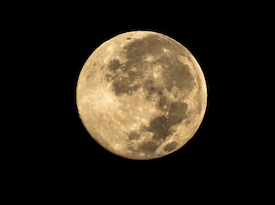

In [9]:
@dds.data_function("/my_image2.png")
def image_moon():
    return Image.open('tut_custom_types_moon.png')
image_moon()

Finally, we check that we can indeed read our file as an image:

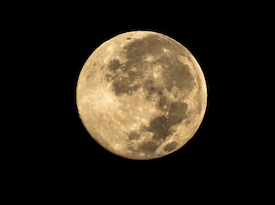

In [11]:
IPython.display.Image(filename=f'{data_dir}/my_image2.png')  